In [1]:
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score, roc_auc_score
from catboost import CatBoostClassifier

## Author
- Han Jiang
- jianghan2013@gmail.com

# 0 Read the raw data

- Source of the data: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
- **bank-addtional-full.csv** is chosen since it contains the latest data 

In [2]:
"""Read the data"""
file = "bank-additional-full.csv"
df_raw = pd.read_csv(file, sep=";")
print("The shape of data", df_raw.shape)

The shape of data (41188, 21)


## Attribute information
### Bank client data:
- 1 - age (numeric)
- 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- 5 - default: has credit in default? (categorical: 'no','yes','unknown')
- 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
- 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

### Related with the last contact of the current campaign:
- 8 - contact: contact communication type (categorical: 'cellular','telephone')
- 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:
- 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 - previous: number of contacts performed before this campaign and for this client (numeric)
- 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### Social and economic context attributes
- 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
- 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 20 - nr.employed: number of employees - quarterly indicator (numeric)

## Target variable
- The **classification goal** is to predict if the client will subscribe (yes/no) a term deposit (variable y).
- 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
"""Show the columns of the dataframe"""
df_raw.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'], dtype='object')

# 1 EDA for time series problem 
- The data is ordered by **date** (from May 2008 to November 2010)
- Since the data only contain month infomation, I convert the month back to date based on the chronologial order

In [4]:
"""Get month change index"""
def get_start_index_of_each_month(df_raw):
    months = []
    for i,row in df_raw.iterrows():
        month_i = row["month"]
        if i == 0:
            months.append((month_i, i))
        else:
            if month_i != months[-1][0]:
                months.append((month_i, i))
    return months

In [5]:
months_start_index = get_start_index_of_each_month(df_raw)

### Start index of each month and missing months
- The starting month is May of 2008, and the ending month is Nov of 2010
- Months of **Jan and Feb** of 2009 and 2010 are **missing**

In [6]:
print("The starting index of each month")
print(months_start_index)

The starting index of each month
[('may', 0), ('jun', 7763), ('jul', 12137), ('aug', 18822), ('oct', 23997), ('nov', 24064), ('dec', 27680), ('mar', 27690), ('apr', 27972), ('may', 30430), ('jun', 36224), ('jul', 36939), ('aug', 37117), ('sep', 37887), ('oct', 38154), ('nov', 38601), ('dec', 38958), ('mar', 39130), ('apr', 39394), ('may', 39568), ('jun', 39780), ('jul', 40009), ('aug', 40320), ('sep', 40553), ('oct', 40856), ('nov', 41060)]


In [7]:
print("The months in the data")
print(df_raw["month"].unique() )

The months in the data
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']


In [8]:
"""Make a copy of raw dataframe"""
df = df_raw.copy()

## Analysis of y variable
- y = yes only account for a small portion of the data, so this is an imbalanced dataset

In [9]:
"""Analysis of y variable"""
df["y"].value_counts() # indicating highly inbalanced data, choose precision recall over ROC

no     36548
yes     4640
Name: y, dtype: int64

## Add an approximate date
- Add an approximate date back by adding the year back and using the first day of each month to present the date
- 2008 index from [0, 27690)
- 2009 index from [27690, 39130)
- 2010 index from [39130, the end)

In [10]:
"""Add year back"""
df["year"] = 2008
df.iloc[27690: 39130]["year"] = 2009
df.iloc[39130:]["year"] = 2010

In [11]:
"""Map month name to number"""
month_map = {
    'mar':3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12,
}
df["month_raw"] = df_raw["month"]
df["month"] = df_raw["month"].map(month_map).astype(int)
df["day"] = 1

In [12]:
"""Add the date back"""
df["date"] = pd.to_datetime(df[["year", "month", "day"]])

## Compute statistics given the month
- Numbers of clients that are contacted per month; 
- Numbers of clients that subscribe the service (y = yes)
- Convertion rate, the proprotion of clients subcribed the term deposit over clients that are contacted 
- The average employment varation rate per month
- The average consumer price index per month
- The average consumer confidence index per month
- The average number of employees per month

In [13]:
df["y"] = df_raw["y"].map({"yes": 1, "no": 0})
temp = df[["date", "y", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "nr.employed", "euribor3m"]]\
    .groupby("date").agg(
        { "y":["count", "sum", "mean"],
          "emp.var.rate":["mean"],
          "cons.price.idx":["mean"],
          "cons.conf.idx":["mean"],
          "nr.employed": ["mean"],
          "euribor3m": ["mean"],
        }
)
df_stats = pd.DataFrame()
df_stats["n_clients"] = temp["y"]["count"]
df_stats["n_yes"] = temp["y"]["sum"]
df_stats["yes_rate"] = temp["y"]["mean"]
df_stats["mean_emp.var.rate"] = temp["emp.var.rate"]["mean"]
df_stats["mean_cons.price.idx"] = temp["cons.price.idx"]["mean"]
df_stats["mean_cons.conf.idx"] = temp["cons.conf.idx"]["mean"]
df_stats["mean_nr.employed"] = temp["nr.employed"]["mean"]
df_stats["mean_euribor3m"] = temp["euribor3m"]["mean"]
df_stats

,n_clients,n_yes,yes_rate,mean_emp.var.rate,mean_cons.price.idx,mean_cons.conf.idx,mean_nr.employed,mean_euribor3m
date,,,,,,,,
2008-05-01,7763,240,0.030916,1.1,93.994,-36.4,5191.0,4.857663
2008-06-01,4374,188,0.042981,1.4,94.465,-41.8,5228.1,4.931639
2008-07-01,6685,407,0.060883,1.4,93.918,-42.7,5228.1,4.961587
2008-08-01,5175,271,0.052367,1.4,93.444,-36.1,5228.1,4.964804
2008-10-01,67,42,0.626866,-0.1,93.798,-40.4,5195.8,4.923776
2008-11-01,3616,190,0.052544,-0.1,93.200,-42.0,5195.8,4.114895
2008-12-01,10,1,0.100000,-0.2,92.756,-45.9,5176.3,3.493400
2009-03-01,282,126,0.446809,-1.8,92.843,-50.0,5099.1,1.646220
2009-04-01,2458,442,0.179821,-1.8,93.075,-47.1,5099.1,1.411722


In [14]:
idx_after_2019_Jun = df_stats.index >= "2009-06-01"
idx_before_2019_Jun = ~idx_after_2019_Jun

In [15]:
"""Stats before 2019 June"""
df_stats.loc[idx_before_2019_Jun, ["n_clients", "n_yes", "yes_rate"]].describe()

,n_clients,n_yes,yes_rate
count,10.0000,10.000000,10.000000
mean,3622.4000,243.100000,0.168362
std,2836.6617,171.509281,0.203215
min,10.0000,1.000000,0.030916
25%,826.0000,141.500000,0.052411
50%,3995.0000,215.000000,0.075660
75%,5639.2500,373.000000,0.159866
max,7763.0000,524.000000,0.626866


In [16]:
"""Stats after 2019 June"""
df_stats.loc[idx_after_2019_Jun, ["n_clients", "n_yes", "yes_rate"]].describe()

,n_clients,n_yes,yes_rate
count,16.000000,16.000000,16.000000
mean,310.250000,138.062500,0.469884
std,186.553835,61.374771,0.076819
min,128.000000,58.000000,0.342857
25%,197.500000,96.000000,0.401264
50%,248.500000,121.000000,0.468919
75%,322.500000,170.000000,0.525634
max,770.000000,264.000000,0.575472


## Visualize those statistics over time

In [17]:
def plot_line(col1, col2, y1_name, y2_name, df, set_log=False):
    fig, ax1 = plt.subplots(figsize=(8,4))
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(y1_name, color=color)
    ax1.plot(df_stats[col1], 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    if set_log:
        ax1.set_yscale('log')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2_name, color=color)  # we already handled the x-label with ax1
    #ax2.plot(df_y_count_new["y"]["mean"], 'o-', color=color)
    ax2.plot(df_stats[col2], 'o-')
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

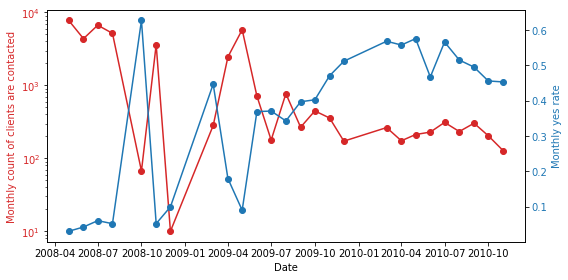

In [18]:
""" Monthly count of clients (left y axis) vs monthly yes rate (right y axis)"""
plot_line("n_clients", "yes_rate",
          "Monthly count of clients are contacted", "Monthly yes rate", df_stats, True)


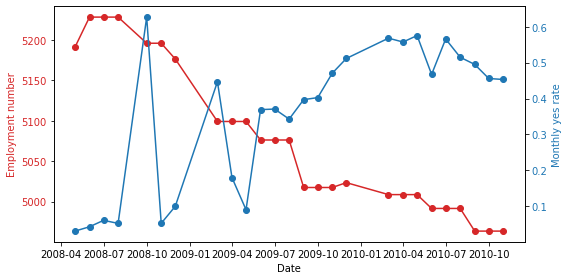

In [19]:
""" Count of employment (left y axis) vs monthly yes rate (right y axis)"""
plot_line("mean_nr.employed", "yes_rate",
          "Employment number", "Monthly yes rate", df_stats, False)

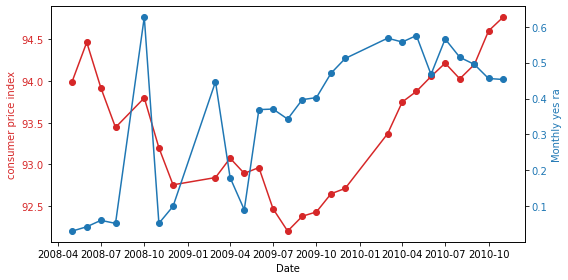

In [20]:
""" Consumer price index (left y axis) vs Monthly yes ra (right y axis)"""
plot_line("mean_cons.price.idx", "yes_rate",
          "consumer price index", "Monthly yes ra", df_stats, False)

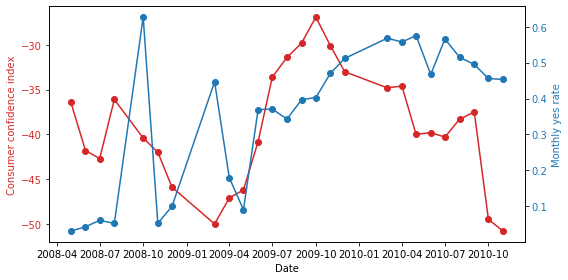

In [21]:
""" Consumer confidence index (left y axis) vs Yes rate (right y axis)"""
plot_line("mean_cons.conf.idx", "yes_rate",
          "Consumer confidence index", "Monthly yes rate", df_stats, False)

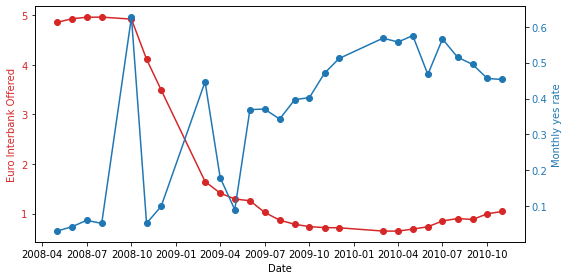

In [22]:
""" Euro Interbank Offered 3 month rate   (left y axis) vs Yes rate (right y axis)"""
plot_line("mean_euribor3m", "yes_rate",
          "Euro Interbank Offered", "Monthly yes rate", df_stats, False)

## Summary for time series analysis
- 1) There is a significant pattern change around 2009-June for **monthly count of clients being contact** and **monthly yes rate**
- 1a) Before 2009 June, The **count of clients per month** has an averge 3.6K/month with maximum of 7.8K/month
	- The count varation is 2.8K/ month, which is quite significant
	- The **monthly yes rate** is 16.8% with great standard deviation of 20%
- 1b) After 2009 June, the count of clients drops to a average of 310/month with a smaller standard deviation of 187.
	the yes rate increases to to average of 47% with a standard deviation of 7.7%.
- 2) The **employment number** decreases over time from maxium of 5200 at 2008 April to a mimimum of 4963 at 2010 October. The decrease of employment number might indicate low performance employees are laid off, that results in the higher yes rate. 
- 3) The consumer price index show a downward tend and reach to bottom at 2009 Auguest. It then bounds back and remain increasing. It show a some degree of **positive correlation** with the yes reate especially after 2009 Auguest. 
- 4) The **consumer confidence index** shows much more complicated pattern. It starts a downward tend and reaches the bottom at 2009 March. It then bounds back afterward and reaches the peak at 2009 October. It then starts to decrease again. The correaltion with yes rate mains less clear
- 5) The **Euro Interbank offered rate** decrease from 5% to around 1% at 2009 at remain very stable, this shows a **negative correlation** with the monthly yes rate 

## Insights of time series analysis
1. The data shows that the monthly yes rate increase from 16.8% to 47% after 2009 June. One possible reason is that the **bank utlizes a more effetive compaign** or a **leaner and more productive workforce structure** as shown by the **decrease of employment number** , since the count of clents being contact decreases from 3.6/month to 310/month
2. The second possible reason may be the impact of **social factors** as reflected by the consumer price and consumer confidence, and Euro Interbank offered rate. Also the financial crisis that happened at 2008 might be the driving force for both the trend and also brings the fluctuation.

In [23]:
""" Check for missing, and no feature has missing values"""
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
year              0
month_raw         0
day               0
date              0
dtype: int64

# 2 EDA for other numerical variables

In [24]:
idx_after = df["date"] >= "2009-06-01"
idx_before = ~ idx_after
idx_yes = df["y"] == 1

In [25]:
"""Stats before 2009-06"""
cols= ["age", 'campaign','duration', 'pdays', 'previous']
df.loc[idx_before,cols].describe()

,age,campaign,duration,pdays,previous
count,36224.000000,36224.000000,36224.000000,36224.000000,36224.000000
mean,39.695533,2.668590,254.933746,991.596621,0.095682
std,9.398074,2.900062,260.850367,85.433991,0.310148
min,18.000000,1.000000,0.000000,0.000000,0.000000
25%,32.000000,1.000000,99.000000,999.000000,0.000000
50%,38.000000,2.000000,175.000000,999.000000,0.000000
75%,47.000000,3.000000,314.000000,999.000000,0.000000
max,95.000000,56.000000,4918.000000,999.000000,3.000000


In [26]:
"""Stats after 2009-06"""
cols= ["age",'campaign', 'duration','pdays', 'previous']
df.loc[idx_after,cols].describe()

,age,campaign,duration,pdays,previous
count,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000
mean,42.421434,1.830580,282.740330,749.968372,0.736906
std,15.814360,1.294178,246.160115,430.458247,0.984301
min,17.000000,1.000000,1.000000,0.000000,0.000000
25%,30.000000,1.000000,131.000000,22.000000,0.000000
50%,37.000000,1.000000,215.000000,999.000000,0.000000
75%,53.000000,2.000000,351.250000,999.000000,1.000000
max,98.000000,16.000000,3785.000000,999.000000,7.000000


## Histograms of all clients

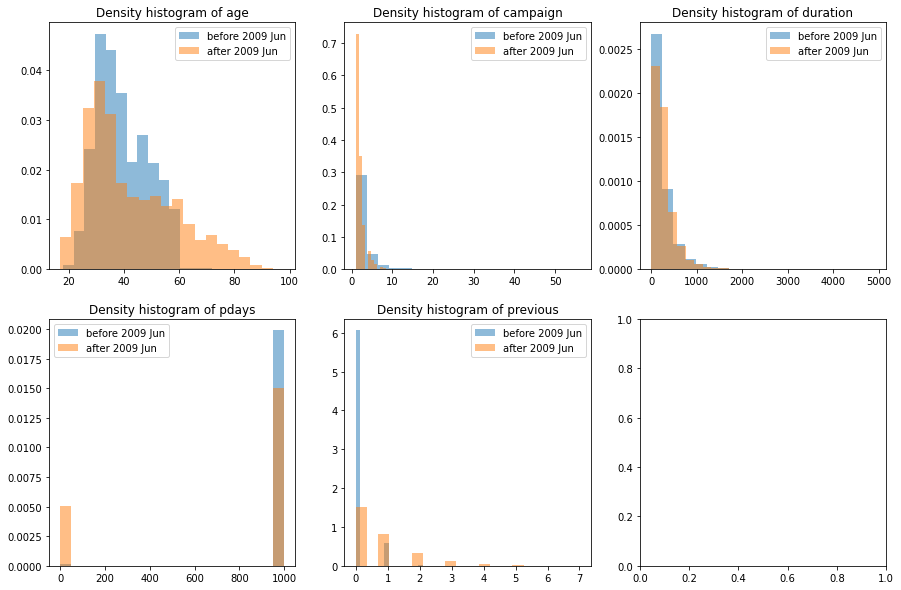

In [27]:

bins = 20
alpha = 0.5
density = True

fig, axs = plt.subplots(2, 3, figsize=(15,10))
col = "age"
i, j = 0, 0 
axs[i, j].hist(df.loc[idx_before,col], bins=bins, alpha=alpha, density=density, label="before 2009 Jun")
axs[i, j].hist(df.loc[idx_after,col], bins=bins, alpha=alpha, density=density, label="after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()

col = 'campaign'
i, j = 0, 1 
axs[i, j].hist(df.loc[idx_before,col], bins=bins, alpha=alpha, density=density, label="before 2009 Jun")
axs[i, j].hist(df.loc[idx_after,col], bins=bins, alpha=alpha, density=density, label="after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()

col = 'duration'
i, j = 0, 2 
axs[i, j].hist(df.loc[idx_before,col], bins=bins, alpha=alpha, density=density, label="before 2009 Jun")
axs[i, j].hist(df.loc[idx_after,col], bins=bins, alpha=alpha, density=density, label="after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()


col = 'pdays'
i, j = 1, 0 
axs[i, j].hist(df.loc[idx_before,col], bins=bins, alpha=alpha, density=density, label="before 2009 Jun")
axs[i, j].hist(df.loc[idx_after,col], bins=bins, alpha=alpha, density=density, label="after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()

col = 'previous'
i, j = 1, 1 
axs[i, j].hist(df.loc[idx_before,col], bins=bins, alpha=alpha, density=density, label="before 2009 Jun")
axs[i, j].hist(df.loc[idx_after,col], bins=bins, alpha=alpha, density=density, label="after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()


## Histograms for clients that subscribe the deposit service (y= yes)

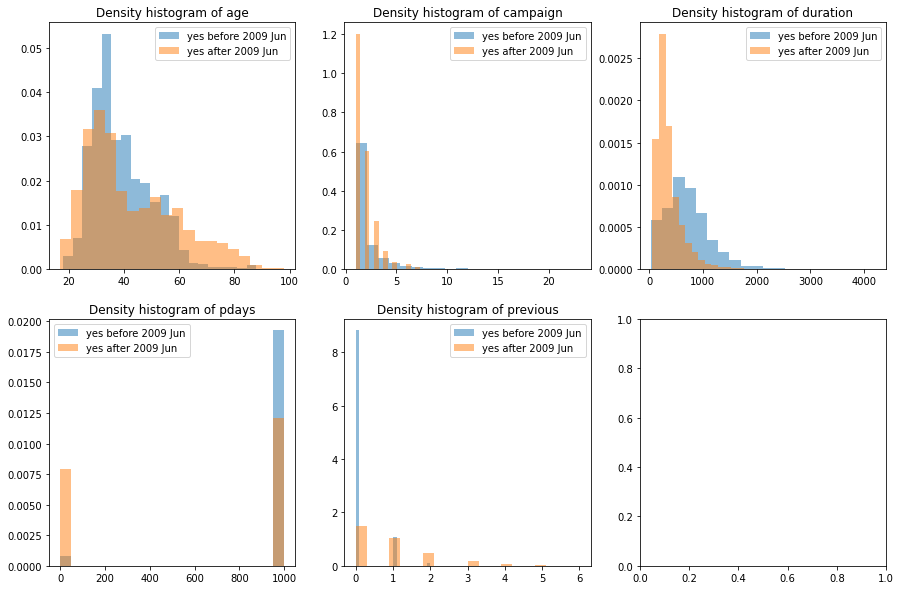

In [28]:

bins = 20
alpha = 0.5
density = True


fig, axs = plt.subplots(2, 3, figsize=(15,10))


col = "age"
i, j = 0, 0 
axs[i, j].hist(df.loc[idx_before&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes before 2009 Jun")
axs[i, j].hist(df.loc[idx_after&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()

col = 'campaign'
i, j = 0, 1 
axs[i, j].hist(df.loc[idx_before&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes before 2009 Jun")
axs[i, j].hist(df.loc[idx_after&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()

col = 'duration'
i, j = 0, 2 
axs[i, j].hist(df.loc[idx_before&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes before 2009 Jun")
axs[i, j].hist(df.loc[idx_after&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()


col = 'pdays'
i, j = 1, 0 
axs[i, j].hist(df.loc[idx_before&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes before 2009 Jun")
axs[i, j].hist(df.loc[idx_after&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()

col = 'previous'
i, j = 1, 1 
axs[i, j].hist(df.loc[idx_before&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes before 2009 Jun")
axs[i, j].hist(df.loc[idx_after&idx_yes,col], bins=bins, alpha=alpha, density=density, label="yes after 2009 Jun")
axs[i, j].set_title(f'Density histogram of {col}')
axs[i, j].legend()

## Insights of other numerical variables
### For all clients
- 1. The **average age** increase from 39.7 to 42.4 after 2009 June with a wider range. The main reason is because before 2009 June, age group >= 60 are not contacted, and age group between 30 - 50 are the main focus

- 2. Before 2009 June, the median of concats of current campaign is 2, whereas the median concats decrease to 1, meaning clients are contacted less overall after 2009 June. Also The **median call duration** increases from 175 to 215. Those two stats indicate the campaign is more effective after June 2009

- 3. The proportion of 999 in **p_days** decreases, meaning the proportion of people that were contacted before increases. Also average of contacts by the last campaign (**p_vious**). The two indicates that, after 2009, the campaign focuses more on the clients that were contacted in the previous campaign intead of new clients.

### For clients that subscribe the deposit service (y = yes)
- 1. The clients that subscribe the deposit service (y = yes) group show similar tends as the all clients. The duration after for the yes group reduces compared to the group prior 2009 June.

## Correlation analysis (including y variable)

In [29]:
cols= ["age", 'campaign','duration', 'pdays', 'previous', "emp.var.rate", "cons.price.idx", "cons.conf.idx", "nr.employed", "euribor3m", "y"]

<AxesSubplot:>

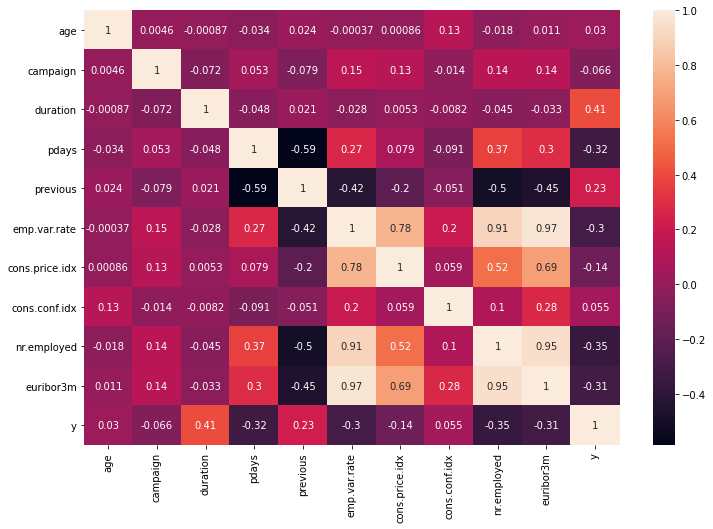

In [30]:
plt.figure(figsize=(12,8))
corr = df[cols].corr()
sns.heatmap(corr, annot=True)

## Insight of correlation matrix
- 1. There is no significant correlated feature with y, the one that correlates highest with y is duration, which will be excluded in the model to provide a realistc predictive model
- 2. There are some social factors that have a higher degree of correlation. Those includes emp.var.rate, cons.conf.index, cons.price.idx
- 3. Due to 2, **euribor3m** and **nr.employed** are dropped as they highly correlate (>0.9) with emp.var.rate

# 3 EDA for categorical variables

In [31]:
cols_cat = [
    'job', 
     'marital',
     'education',
     'default',
     'housing',
     'loan',
     'contact',
     'month',
     'day_of_week',
     "poutcome"
]

## Unique values for each categorical variables

In [32]:
for col in cols_cat:
    print(col, df[col].unique())

job ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital ['married' 'single' 'divorced' 'unknown']
education ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default ['no' 'unknown' 'yes']
housing ['no' 'yes' 'unknown']
loan ['no' 'yes' 'unknown']
contact ['telephone' 'cellular']
month [ 5  6  7  8 10 11 12  3  4  9]
day_of_week ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome ['nonexistent' 'failure' 'success']


In [33]:
def plot_bar_den(column, data, plot_yes=True):
    # temp df 
    df_1 = pd.DataFrame()
    n = data.shape[0]
    # count categorical values
    df_1['Yes_deposit'] = data[data['y'] == 1][column].value_counts()
    df_1['No_deposit'] = data[data['y'] == 0][column].value_counts()
    
    df_1["total"] = df_1["Yes_deposit"] + df_1["No_deposit"]
    #temp_1.sort_values("total", inplace=True, ascending=False)
    print(df_1)
    df_1["Yes_rate"] = df_1["Yes_deposit"] / df_1["total"]
    if plot_yes:
        df_1[["Yes_rate"]].plot(kind='bar')
    
        plt.xlabel(f'{column}')
        plt.ylabel('Yes rate')
    else:
        df_1[["total"]].plot(kind='bar')
    
        plt.xlabel(f'{column}')
        plt.ylabel('Total clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show();
    
    

## Plot for yes_rate before 2009 June

               Yes_deposit  No_deposit  total
admin.                 639        8212   8851
blue-collar            511        8435   8946
technician             402        5623   6025
services               221        3503   3724
management             178        2395   2573
retired                117         922   1039
self-employed           92        1170   1262
entrepreneur            91        1276   1367
student                 72         368    440
unemployed              50         749    799
housemaid               43         880    923
unknown                 15         260    275


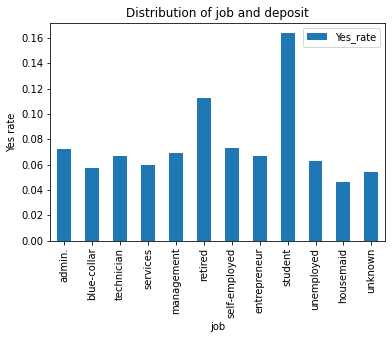

          Yes_deposit  No_deposit  total
married          1371       20966  22337
single            793        8887   9680
divorced          261        3877   4138
unknown             6          63     69


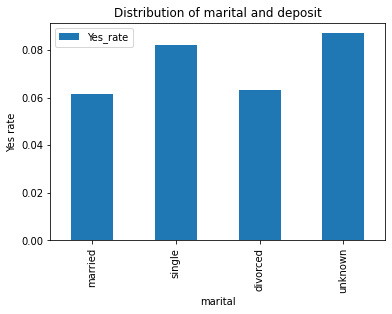

                     Yes_deposit  No_deposit  total
university.degree            795        9346  10141
high.school                  559        7891   8450
basic.9y                     344        5383   5727
professional.course          299        4302   4601
basic.4y                     202        3509   3711
basic.6y                     139        2049   2188
unknown                       91        1300   1391
illiterate                     2          13     15


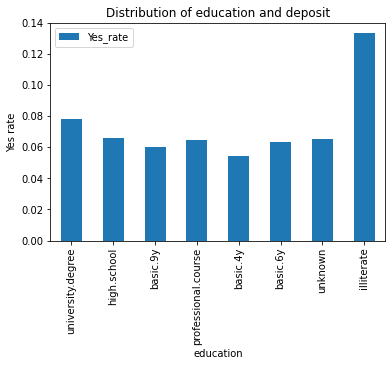

         Yes_deposit  No_deposit  total
no              2042       25699  27741
unknown          389        8091   8480


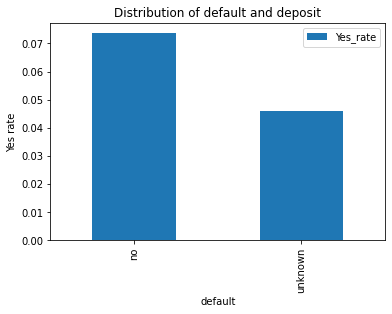

         Yes_deposit  No_deposit  total
yes             1305       17550  18855
no              1077       15435  16512
unknown           49         808    857


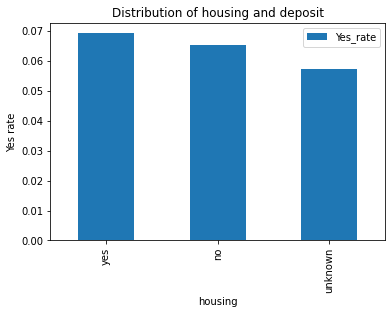

         Yes_deposit  No_deposit  total
no              2010       27808  29818
yes              372        5177   5549
unknown           49         808    857


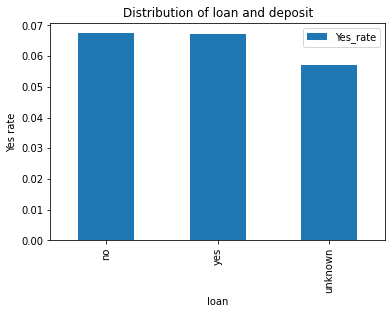

           Yes_deposit  No_deposit  total
cellular          1842       20037  21879
telephone          589       13756  14345


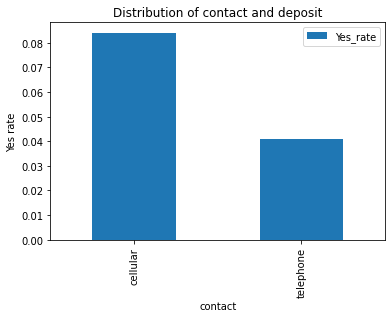

    Yes_deposit  No_deposit  total
5           764       12793  13557
4           442        2016   2458
7           407        6278   6685
8           271        4904   5175
11          190        3426   3616
6           188        4186   4374
3           126         156    282
10           42          25     67
12            1           9     10


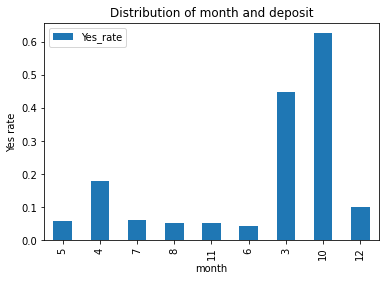

     Yes_deposit  No_deposit  total
thu          572        7061   7633
wed          515        6697   7212
mon          465        6990   7455
fri          444        6498   6942
tue          435        6547   6982


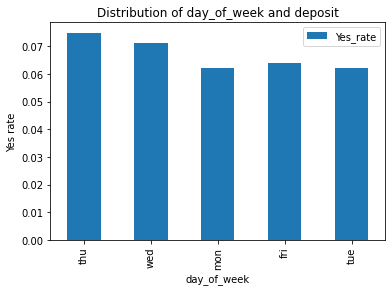

             Yes_deposit  No_deposit  total
nonexistent         2142       30787  32929
failure              199        2840   3039
success               90         166    256


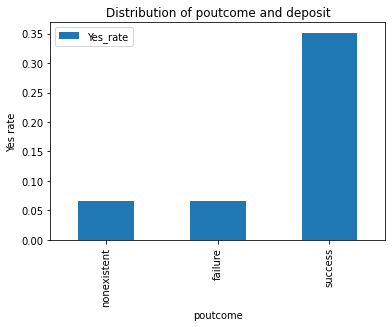

In [34]:
for col in cols_cat:
    plot_bar_den(col, df[idx_before])

##  Plot for yes_rate after 2009 June

               Yes_deposit  No_deposit  total
admin.                 713         858   1571
technician             328         390    718
retired                317         364    681
student                203         232    435
management             150         201    351
blue-collar            127         181    308
services               102         143    245
unemployed              94         121    215
housemaid               63          74    137
self-employed           57         102    159
entrepreneur            33          56     89
unknown                 22          33     55


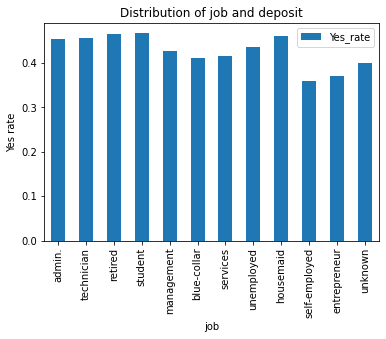

          Yes_deposit  No_deposit  total
married          1161        1430   2591
single            827        1061   1888
divorced          215         259    474
unknown             6           5     11


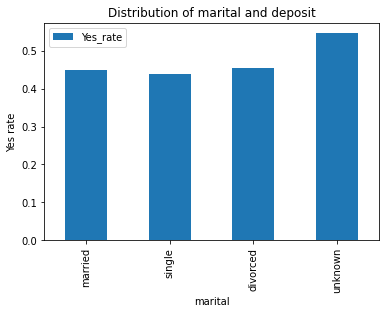

                     Yes_deposit  No_deposit  total
university.degree            875        1152   2027
high.school                  472         593   1065
professional.course          296         346    642
basic.4y                     226         239    465
unknown                      160         180    340
basic.9y                     129         189    318
basic.6y                      49          55    104
illiterate                     2           1      3


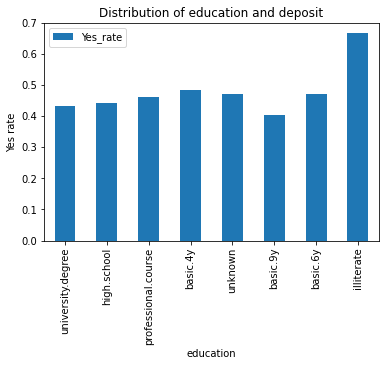

         Yes_deposit  No_deposit  total
no              2155        2692   4847
unknown           54          63    117


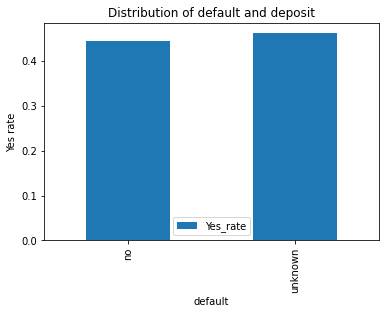

         Yes_deposit  No_deposit  total
yes             1202        1519   2721
no               949        1161   2110
unknown           58          75    133


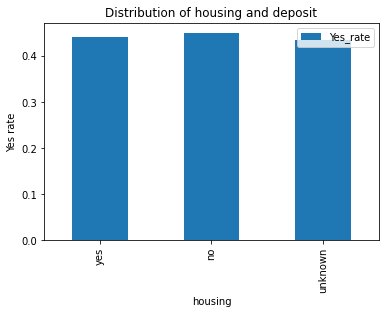

         Yes_deposit  No_deposit  total
no              1840        2292   4132
yes              311         388    699
unknown           58          75    133


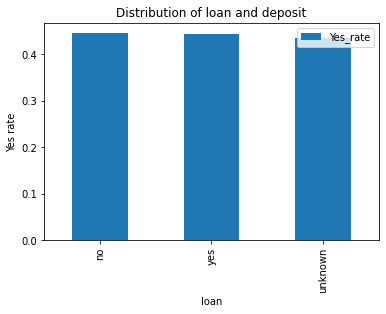

           Yes_deposit  No_deposit  total
cellular          2011        2254   4265
telephone          198         501    699


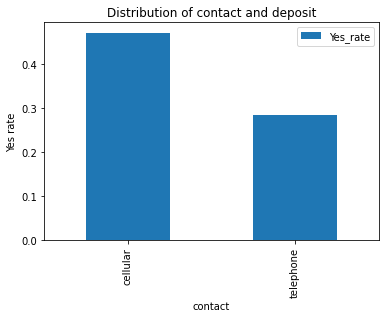

    Yes_deposit  No_deposit  total
8           384         619   1003
6           371         573    944
10          273         378    651
9           256         314    570
7           242         247    489
11          226         259    485
3           150         114    264
5           122          90    212
4            97          77    174
12           88          84    172


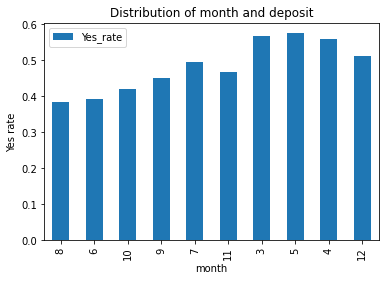

     Yes_deposit  No_deposit  total
tue          518         590   1108
thu          473         517    990
wed          434         488    922
fri          402         483    885
mon          382         677   1059


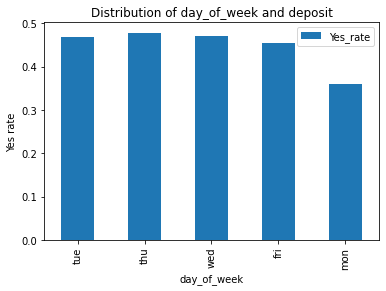

             Yes_deposit  No_deposit  total
nonexistent          999        1635   2634
success              804         313   1117
failure              406         807   1213


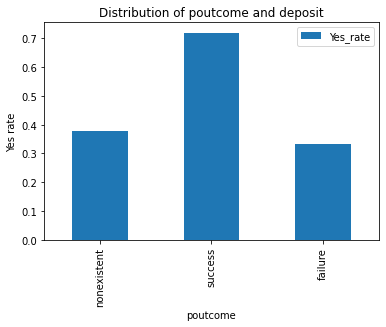

In [35]:
for col in cols_cat:
    plot_bar_den(col, df[idx_after])

## Insights of categorical variables
### Before 2009 June
- 1. For job category, retire and student have a higher yes rate,
- 2. For marriage category, single has a higher yes rate
- 3. For default history, no default has a higher yes rate. 
- 4. For concat type, cellular concat has a higher yes rate.
- 5. For month type, March and Oct have a higher rate
- 6. Loan, housing, education and day of week show similar yes rate across all groups

### After 2009 June
- 1. Celluar concat and March and October have a higher yes rate.
- 2. The rest category including job, marriage, default history, loan, housing, education and day of week show similar yes rate across their groups


# 4 Feature engineering
- 1. One hot encoding for two binary variables: concat and default
- 2. One hot encoding for other categorical variables: day of week, job, marital, education, housing, loan and day_of_week
- 3. Ordinal Encoding for day_of_week as well
- 4. Other process for pdays, previous, poutcome

In [36]:
def data_process(df, do_one_hot=True):
    # categorical variables
    df["concat"] = (df["contact"] == "cellular").astype(int)
    df["default"] = (df["default"] == "no").astype(int)
    
    if do_one_hot:
        cols_one_hot = [
         'job', 
         'marital',
         'education',
         'housing',
         'loan',
         'day_of_week'
        ]

        df_dummies = pd.get_dummies(df[cols_one_hot], dtype=int)
        df = pd.concat([df, df_dummies], axis=1)
        
    # day of week
    days_of_week_map ={
        'mon': 1, 
        'tue': 2, 
        'wed': 3,
        'thu': 4,
        'fri': 5,
    }
    
    df["day_of_week_num"] = df["day_of_week"].map(days_of_week_map)
    df["pdays"] = df["pdays"].replace(999, 0) 
    df["previous"] = df["previous"].apply(lambda x: 1 if x > 0 else 0)
    # binary if were was an outcome of marketing campane
    df["poutcome"] = df.poutcome.map({'nonexistent':0, 'failure':0, 'success':1})
    
    return df

In [37]:
df_proc = data_process(df.copy(), True)

In [38]:
model_num_fm = [
 'age',
 'default',
 'month',
 'day_of_week_num',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'year',
 'day',
 'concat',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes'
]

In [39]:
df_proc[model_num_fm].head()

,age,default,month,day_of_week_num,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,year,day,concat,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,56,1,5,1,1,0,0,0,1.1,93.994,-36.4,2008,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,57,0,5,1,1,0,0,0,1.1,93.994,-36.4,2008,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
2,37,1,5,1,1,0,0,0,1.1,93.994,-36.4,2008,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
3,40,1,5,1,1,0,0,0,1.1,93.994,-36.4,2008,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,56,1,5,1,1,0,0,0,1.1,93.994,-36.4,2008,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


## Categorical features for target encoding (only for catboost model)

In [40]:
model_cat_fm = [
     'job', 
     'marital',
     'education',
     'housing',
     'loan',
     'day_of_week'
]

In [41]:
df_proc[model_cat_fm].head()

,job,marital,education,housing,loan,day_of_week
0,housemaid,married,basic.4y,no,no,mon
1,services,married,high.school,no,no,mon
2,services,married,high.school,yes,no,mon
3,admin.,married,basic.6y,no,no,mon
4,services,married,high.school,no,yes,mon


# 5 Train test split
- 1. Since this is time series data, so **random shuffle** should be avoid
- 2. The train and test should be split in time or **simple time series train test**
- 3. **Rolling train test method**.
    - The train window w starts at the begining of the data, use the future test window with size of k
    - For next train test, the train window move forward by including the last test window, also drops the oldest k points
    - Keep this rolling fashion until the test window reach the end of the dataset.
    - The evaluation of test is done by appending all test windows
- 4. The **simple time series is a special case of rolling train test**.

## Metric
- 1. **average precision**, or the area under the precision and recall as model performance metric

## Define functions for rolling train test

In [42]:
def get_train_index(n=150, L=100, test_ratio=0.2):
    k = int(L * test_ratio)
    w = L - k
    n_trial = (n - L) // k + 1
    train_start = 0
    idx = []
    for i in range(n_trial):
        train_end = train_start + w
        test_start = train_end
        test_end = test_start + k
        idx.append([train_start, train_end, test_start, test_end])
        train_start += k
    return idx

## Define the model evaluation by appending all test results

In [43]:
def model_eval(idx, X, y, use_catboost=False):
    y_train = []
    y_test = []
    y_proba_train = []
    y_proba_test = []
    for train_start, train_end, test_start, test_end in idx:
        print(train_start, train_end, test_start, test_end)
        Xtrain_i = X[train_start: train_end]
        ytrain_i = y[train_start: train_end]
        Xtest_i = X[test_start: test_end]
        ytest_i = y[test_start: test_end]
        if use_catboost:
            model_i = CatBoostClassifier(
                random_seed=1,
                iterations=500,
                thread_count=4,
                depth=7,
                l2_leaf_reg=20,
                auto_class_weights="Balanced"
            )
            cols_cat_idx = np.where((X.dtypes != np.float) & (X.dtypes != np.int))[0]
            model_i.fit(Xtrain_i,
                        ytrain_i,
                eval_set=(Xtest_i, ytest_i),
                cat_features=cols_cat_idx, verbose=0
            )
        else:
            model_i = RandomForestClassifier(
                n_estimators=500,
                n_jobs=4,
                random_state=1,
                class_weight="balanced"
            )
            model_i.fit(Xtrain_i, ytrain_i)
        # predict
        
        ytrain_proba_i = model_i.predict_proba(Xtrain_i)[:,1]
        ytest_proba_i = model_i.predict_proba(Xtest_i)[:,1]
        
        y_proba_train.append(ytrain_proba_i)
        y_train.append(ytrain_i)
        y_proba_test.append(ytest_proba_i)
        y_test.append(ytest_i)
        
    return np.concatenate(y_train), np.concatenate(y_proba_train),\
            np.concatenate(y_test),np.concatenate(y_proba_test), model_i

## For all data, use simple train test time series split
- 1. Catboost
- 2. Random forest

In [44]:
test_ratio = 0.15
idx = get_train_index(df_proc.shape[0], int(df_proc.shape[0] * 1), test_ratio)
print("number of train test folds:", len(idx)) 

number of train test folds: 1


In [45]:
y_train_cat, y_proba_train_cat, y_test_cat, y_proba_test_cat, model_cat = model_eval(
    idx,
    df_proc[model_num_fm],
    df_proc["y"],
    use_catboost=True
)

0 35010 35010 41188


In [46]:
ap_train_cat = average_precision_score(y_train_cat, y_proba_train_cat)
ap_test_cat = average_precision_score(y_test_cat, y_proba_test_cat)
print(f"average precision of train {np.round(ap_train_cat,3)} vs test {np.round(ap_test_cat,3)}")

average precision of train 0.264 vs test 0.49


In [47]:
y_train_rf, y_proba_train_rf, y_test_rf, y_proba_test_rf, model_rf = model_eval(
    idx,
    df_proc[model_num_fm],
    df_proc["y"],
    use_catboost=False
)

0 35010 35010 41188


In [48]:
ap_train_rf = average_precision_score(y_train_rf, y_proba_train_rf)
ap_test_rf = average_precision_score(y_test_rf, y_proba_test_rf)
print(f"average precision of train {np.round(ap_train_rf,3)} vs test {np.round(ap_test_rf,3)}")

average precision of train 0.955 vs test 0.495


Text(0, 0.5, 'Precision')

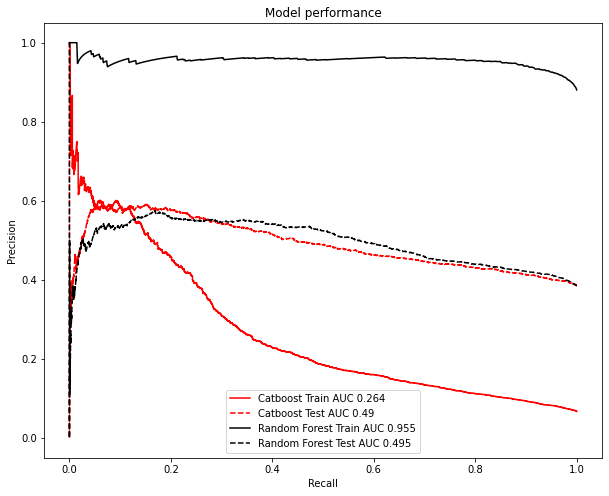

In [49]:
precision_train_cat, recall_train_cat, _ = precision_recall_curve(y_train_cat, y_proba_train_cat)
precision_test_cat, recall_test_cat, _ = precision_recall_curve(y_test_cat, y_proba_test_cat)
precision_train_rf, recall_train_rf, _ = precision_recall_curve(y_train_rf, y_proba_train_rf)
precision_test_rf, recall_test_rf, _ = precision_recall_curve(y_test_rf, y_proba_test_rf)

plt.figure(figsize=(10,8))
plt.plot(recall_train_cat, precision_train_cat, "r-", label=f"Catboost Train AUC {np.round(ap_train_cat,3)}")
plt.plot(recall_test_cat, precision_test_cat, "r--", label=f"Catboost Test AUC {np.round(ap_test_cat,3)}")
plt.plot(recall_train_rf, precision_train_rf, "k-", label=f"Random Forest Train AUC {np.round(ap_train_rf,3)}")
plt.plot(recall_test_rf, precision_test_rf, "k--", label=f"Random Forest Test AUC {np.round(ap_test_rf,3)}")
plt.legend()
plt.title("Model performance")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Only data after 2009 June, use simple train test time series split (test_ratio = 0.15)
- 1. Catboost
- 2. Random forest

In [50]:
test_ratio = 0.15
df_after = df_proc[idx_after]
idx = get_train_index(df_after.shape[0], int(df_after.shape[0] * 1), test_ratio)
print("number of train test folds:", len(idx)) 

number of train test folds: 1


In [51]:
y_train_cat, y_proba_train_cat, y_test_cat, y_proba_test_cat, model_cat = model_eval(
    idx,
    df_after[model_num_fm+model_cat_fm],
    df_after["y"],
    use_catboost=True
)

0 4220 4220 4964


In [52]:
model_cat_simple = model_cat

In [53]:
ap_train_cat = average_precision_score(y_train_cat, y_proba_train_cat)
ap_test_cat = average_precision_score(y_test_cat, y_proba_test_cat)
print(f"average precision of train {np.round(ap_train_cat,3)} vs test {np.round(ap_test_cat,3)}")

average precision of train 0.734 vs test 0.768


In [54]:
y_train_rf, y_proba_train_rf, y_test_rf, y_proba_test_rf, model_rf = model_eval(
    idx,
    df_after[model_num_fm],
    df_after["y"],
    use_catboost=False
)

0 4220 4220 4964


In [55]:
ap_train_rf = average_precision_score(y_train_rf, y_proba_train_rf)
ap_test_rf = average_precision_score(y_test_rf, y_proba_test_rf)
print(f"average precision of train {np.round(ap_train_rf,3)} vs test {np.round(ap_test_rf,3)}")

average precision of train 1.0 vs test 0.74


Text(0, 0.5, 'Precision')

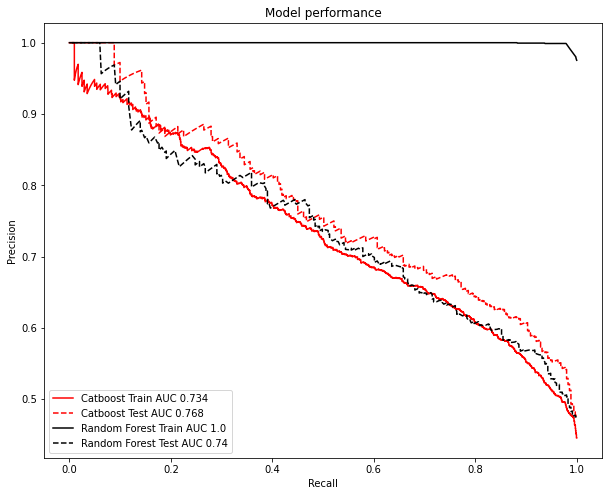

In [56]:
precision_train_cat, recall_train_cat, _ = precision_recall_curve(y_train_cat, y_proba_train_cat)
precision_test_cat, recall_test_cat, _ = precision_recall_curve(y_test_cat, y_proba_test_cat)
precision_train_rf, recall_train_rf, _ = precision_recall_curve(y_train_rf, y_proba_train_rf)
precision_test_rf, recall_test_rf, _ = precision_recall_curve(y_test_rf, y_proba_test_rf)

plt.figure(figsize=(10,8))
plt.plot(recall_train_cat, precision_train_cat, "r-", label=f"Catboost Train AUC {np.round(ap_train_cat,3)}")
plt.plot(recall_test_cat, precision_test_cat, "r--", label=f"Catboost Test AUC {np.round(ap_test_cat,3)}")
plt.plot(recall_train_rf, precision_train_rf, "k-", label=f"Random Forest Train AUC {np.round(ap_train_rf,3)}")
plt.plot(recall_test_rf, precision_test_rf, "k--", label=f"Random Forest Test AUC {np.round(ap_test_rf,3)}")
plt.legend()
plt.title("Model performance")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Only data after 2009 June, use rolling train test
- 1. Catboost
- 2. Random forest

In [57]:
test_ratio = 0.15
df_after = df_proc[idx_after]
idx = get_train_index(df_after.shape[0], int(df_after.shape[0] * 0.7), test_ratio)
print("number of train test folds:", len(idx)) 

number of train test folds: 3


In [58]:
y_train_cat, y_proba_train_cat, y_test_cat, y_proba_test_cat, model_cat = model_eval(
    idx,
    df_after[model_num_fm],
    df_after["y"],
    use_catboost=True
)

0 2953 2953 3474
521 3474 3474 3995
1042 3995 3995 4516


In [59]:
ap_train_cat = average_precision_score(y_train_cat, y_proba_train_cat)
ap_test_cat = average_precision_score(y_test_cat, y_proba_test_cat)
print(f"average precision of train {np.round(ap_train_cat,3)} vs test {np.round(ap_test_cat,3)}")

average precision of train 0.773 vs test 0.732


In [60]:
y_train_rf, y_proba_train_rf, y_test_rf, y_proba_test_rf, model_rf = model_eval(
    idx,
    df_after[model_num_fm],
    df_after["y"],
    use_catboost=False
)

0 2953 2953 3474
521 3474 3474 3995
1042 3995 3995 4516


In [61]:
ap_train_rf = average_precision_score(y_train_rf, y_proba_train_rf)
ap_test_rf = average_precision_score(y_test_rf, y_proba_test_rf)
print(f"average precision of train {np.round(ap_train_rf,3)} vs test {np.round(ap_test_rf,3)}")

average precision of train 1.0 vs test 0.703


Text(0, 0.5, 'Precision')

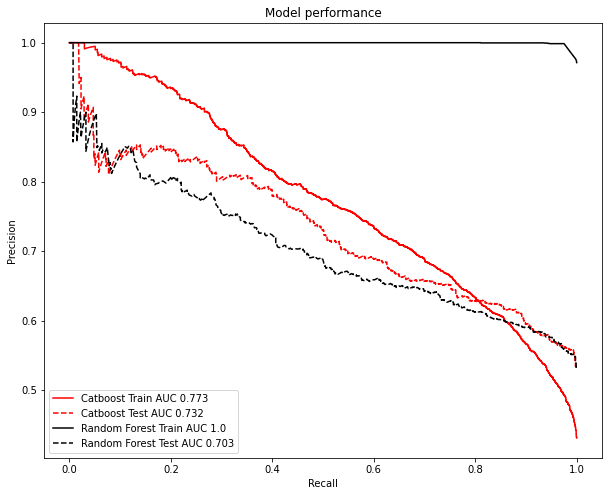

In [62]:
precision_train_cat, recall_train_cat, _ = precision_recall_curve(y_train_cat, y_proba_train_cat)
precision_test_cat, recall_test_cat, _ = precision_recall_curve(y_test_cat, y_proba_test_cat)
precision_train_rf, recall_train_rf, _ = precision_recall_curve(y_train_rf, y_proba_train_rf)
precision_test_rf, recall_test_rf, _ = precision_recall_curve(y_test_rf, y_proba_test_rf)

plt.figure(figsize=(10,8))
plt.plot(recall_train_cat, precision_train_cat, "r-", label=f"Catboost Train AUC {np.round(ap_train_cat,3)}")
plt.plot(recall_test_cat, precision_test_cat, "r--", label=f"Catboost Test AUC {np.round(ap_test_cat,3)}")
plt.plot(recall_train_rf, precision_train_rf, "k-", label=f"Random Forest Train AUC {np.round(ap_train_rf,3)}")
plt.plot(recall_test_rf, precision_test_rf, "k--", label=f"Random Forest Test AUC {np.round(ap_test_rf,3)}")
plt.legend()
plt.title("Model performance")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Insights
### When use all data and split train test by time
- 1. The performance from train to test change significantly if using all data, for both models.
- 2. This is due to a signficant change in the pattern after 2009 June.  the which violate the patterns from train to test remain the same

### When only keep data after June 2009, and split train test by time
- 1. For catboost model, the test AUC is 0.768 and Random forest is 0.74. However the train and test performance is similar for catboost whereas the random forest has a significant performance drop. This indicates catboost produces a more stable model. so the catboost is perferred.
- 2. Similar conslusion holds for rolling train test. 

## Feature importance
- 1. use simple train test after 2009 June
- 2. based on catboost model, using simple train test split
- 3. **pdays, day_of_week, poutcome, job, and education** are the top features

In [63]:
df_imp = model_cat_simple.get_feature_importance(prettified=True)
df_imp = df_imp.set_index("Feature Id")
df_imp = df_imp.sort_values("Importances", ascending=True)

<AxesSubplot:ylabel='Feature Id'>

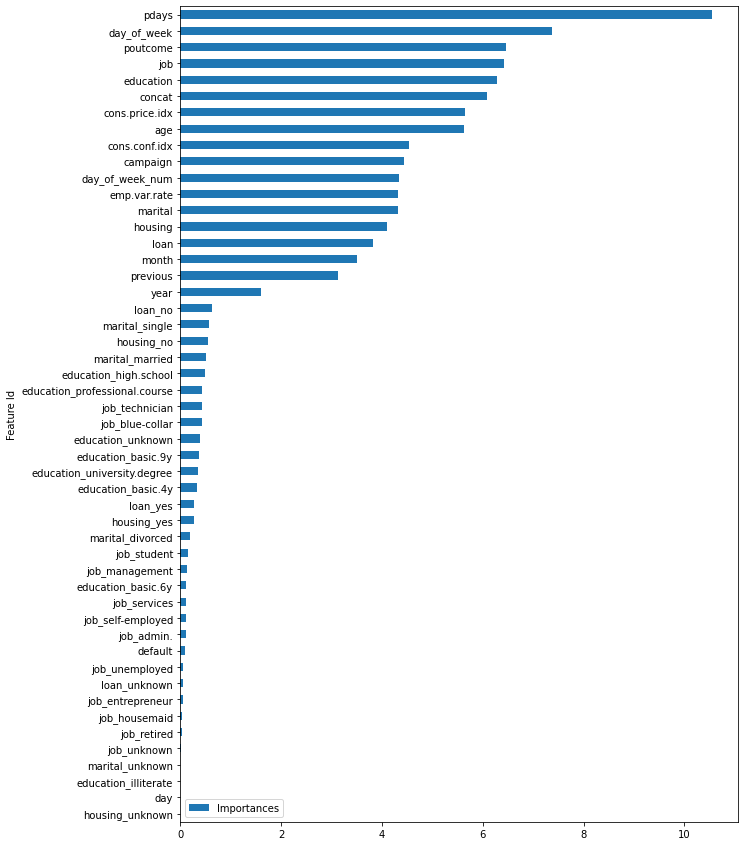

In [64]:
df_imp.plot.barh(figsize=(10,15))